# Score matching notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm   # For progress bar

# Define the neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 3)
        self.fc3 = nn.Linear(3, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x =torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def energy(x):
    return x**2

def get_sample(n):
    beta = 1/0.001
    x = torch.rand(n)*20 -10
    y = torch.exp(-beta*energy(x))
    z = torch.rand(n)
    i = (y - z)>0
    return x[i]
# a = sample(10000)
# print(a.shape)
# # print(a)
# print(torch.max(a))
# print(torch.min(a))

# plt.hist(a.detach().numpy(),bins=5)
# plt.show()
# Create an input tensor
# input_tensor = torch.randn((20, 4, 3), requires_grad=True)


# Define the score matching loss function
def score_matching_loss(output,input,input_noise):
    input_grad = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    # loss = torch.mean(torch.sum(input_grad**2))
    loss = 0.5* torch.norm(input_grad-input_noise,p=2)**2
    return loss

# set progess bar
# tepoch = tqdm(range(1000000))
# for epoch in tepoch:
#     # Create an input tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create an instance of the network
net = MyNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001)

samples = get_sample(1000000)
print("sample shape:",samples.shape)


/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sample shape: torch.Size([2805])


In [ ]:
print("sample shape:",samples.shape)
for epoch in range(20):
    running_loss = 0.0
    with tqdm(samples, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            optimizer.zero_grad()
            # set progress bar description
            tepoch.set_description(f"Epoch {epoch}")
            
            sample = sample.to(device)
            input_tensor = torch.tensor(sample.unsqueeze(0), requires_grad=True).to(device)
            input_noise = torch.randn(1, requires_grad=True).to(device)
            input_tensor = input_tensor + input_noise
            
            # Pass the input through the network
            output = net(input_tensor)
            # Compute the score matching loss
            loss = score_matching_loss(output,input_tensor,input_noise)

            # print("Loss:", loss.item())
            running_loss += loss.item()
            # Perform backpropagation and update the network's parameters
            
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            # update progress bar
            tepoch.set_postfix(loss=round(loss.item(),3),running_loss=round(running_loss/(i+1),3))
            
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')


In [8]:
samples = get_sample(100000)
samples = samples.unsqueeze(1).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create an instance of the network
net = MyNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001)

for epoch in range(30):
    optimizer.zero_grad()

    input_tensor = torch.tensor(samples, requires_grad=True).to(device)
    input_noise = torch.randn(1, requires_grad=True).to(device)
    input_tensor = input_tensor + input_noise
    # Pass the input through the network
    output = net(input_tensor)
    # Compute the score matching loss
    loss = score_matching_loss(output,input_tensor,input_noise)
    print(f"epoch:{epoch}, loss:{round(loss.item()/samples.shape[0],3)}")
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()

epoch:0, loss:0.117
epoch:1, loss:0.001
epoch:2, loss:0.004
epoch:3, loss:0.149
epoch:4, loss:0.44
epoch:5, loss:0.006
epoch:6, loss:0.108
epoch:7, loss:0.006
epoch:8, loss:0.083
epoch:9, loss:0.401
epoch:10, loss:0.163
epoch:11, loss:0.275
epoch:12, loss:0.735
epoch:13, loss:0.168
epoch:14, loss:3.656
epoch:15, loss:0.018
epoch:16, loss:0.781
epoch:17, loss:0.004
epoch:18, loss:0.573
epoch:19, loss:0.001
epoch:20, loss:0.034
epoch:21, loss:0.204
epoch:22, loss:0.33
epoch:23, loss:2.654
epoch:24, loss:0.043
epoch:25, loss:0.248
epoch:26, loss:0.293
epoch:27, loss:0.135
epoch:28, loss:0.423
epoch:29, loss:0.043


/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


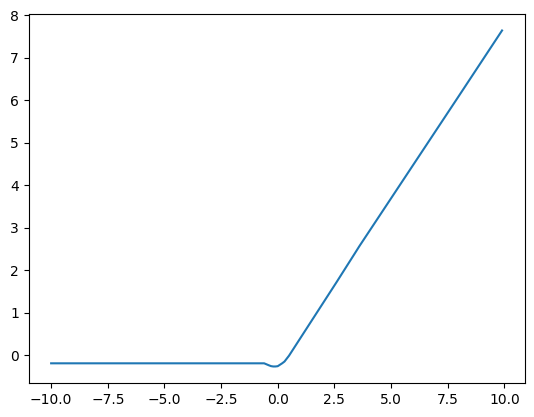

In [9]:
# Generate a plot of the network's output
torch_range = torch.arange(-10,10,0.1).to(device)
y = net(torch_range.unsqueeze(1))
plt.plot(torch_range.detach().cpu().numpy(),y.detach().cpu().numpy())